# Analysis for Schuler, Yang, & Newport (JML submission)

*by Katie Schuler* 
*last updated 2021-03-29*


## Setting up

Before we do the analysis, we need to load in our libraries and read in our data. I'll also include a few boilerplate things that make figures pretty, etc. As always, I'll print the session info so people can see what the analysis environment was like. Note that I did this analysis in the [exbuilder/jupyter:r-4.0.3](https://hub.docker.com/r/exbuilder/jupyter/tags?page=1&ordering=last_updated) container. 

In [1]:
# load tidyverse, but be quiet about it
options(tidyverse.quiet = TRUE)
library(tidyverse)

# load other libraries we'll need 
library(knitr) # for nice tables
library(gridExtra) # put two figures next to each other
library(broom) # make ttable output look pretty
library(lme4) # for mixed effects models

# turn off annoying "summarise()" warning in new dplyr
options(dplyr.summarise.inform = FALSE)

# set all plots to classic theme and center titles
theme_set(theme_classic(base_size = 20))
theme_update(plot.title = element_text(hjust = 0.5))



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [2]:
# print session info so we can see what computing environment was like
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lme4_1.1-26     Matrix_1.3-2    broom_0.7.4     gridExtra_2.3  
 [5] knitr_1.31      forcats_0.5.1   stringr_1.4.0   dplyr_1.0.4    
 [9] purrr_0.3.4     readr_1.4.0     tidyr_1.1.2     tibble_3.0.6   
[13] ggplot2_3.3.3   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6        lubridate_1.7.9.2 

In [3]:
# read in data
exp1_prod <- read.csv('data/exp1_production_data.csv')
exp2_prod <- read.csv('data/exp2_production_data.csv')
exp2_rate <- read.csv('data/exp2_rating_data.csv')

## Experiment 1

In [4]:
exp1_production <- filter(exp1_prod, corr_noun == TRUE) %>% 

    # count how many corr trials each participant had
    group_by(random_id, .drop = FALSE) %>%
    add_tally(name = 'n') %>%
    ungroup %>%

    # then groupby marker_type and fill in any the participant didn't use with 0
    group_by(age_group, condition, language, n, random_id, marker_type, .drop = FALSE) %>%
    tally(name = 'n_marker') %>%
    ungroup %>%
    complete(nesting(age_group, condition, language, random_id, n), nesting(marker_type), fill = list(n_marker = 0)) %>%
   
    # reorder the factors so they look nice in our plots
    mutate(
      usage = n_marker/n*100,
      condition = factor(condition, levels = c("5R4E", "3R6E")),
      age_group = factor(age_group, levels = c("child", "adult"), labels = c("Child", "Adult")),
      marker_type = factor(marker_type, levels = c("R", "e", "null", "other")),
      experiment = "Experiment 1"
    )



### Participants



In [5]:
# get the number of participants in each age group / condition 
exp1_production %>%
  group_by(age_group, condition) %>%
  summarise(n_participants = n_distinct(random_id)) 

age_group,condition,n_participants
<fct>,<fct>,<int>
Child,5R4E,7
Child,3R6E,8
Adult,5R4E,10
Adult,3R6E,10


### Results

The Tolerance Principle predicts that children should behave categorically. This means they should use the regular form on ALL test trials (form a productive rule) in the 5R4E condition and use the regular form no more than chance in the 3R6E condition. 

#### Figures



In [6]:
# first get the usage of each marker type by condition and age 
exp1_production_group <- exp1_production %>%  
  group_by(age_group, condition, marker_type) %>%
  summarise(n = n(), mean = mean(usage), sd = sd(usage), sem = sd/sqrt(n)) 

# print usage of regular form for each age_group and condition
exp1_production_group %>% filter(marker_type == "R") 

age_group,condition,marker_type,n,mean,sd,sem
<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Child,5R4E,R,7,91.66667,22.04793,8.333333
Child,3R6E,R,8,16.85606,34.50744,12.200221
Adult,5R4E,R,10,65.00000,34.20165,10.815512
Adult,3R6E,R,10,52.04545,33.18195,10.493055


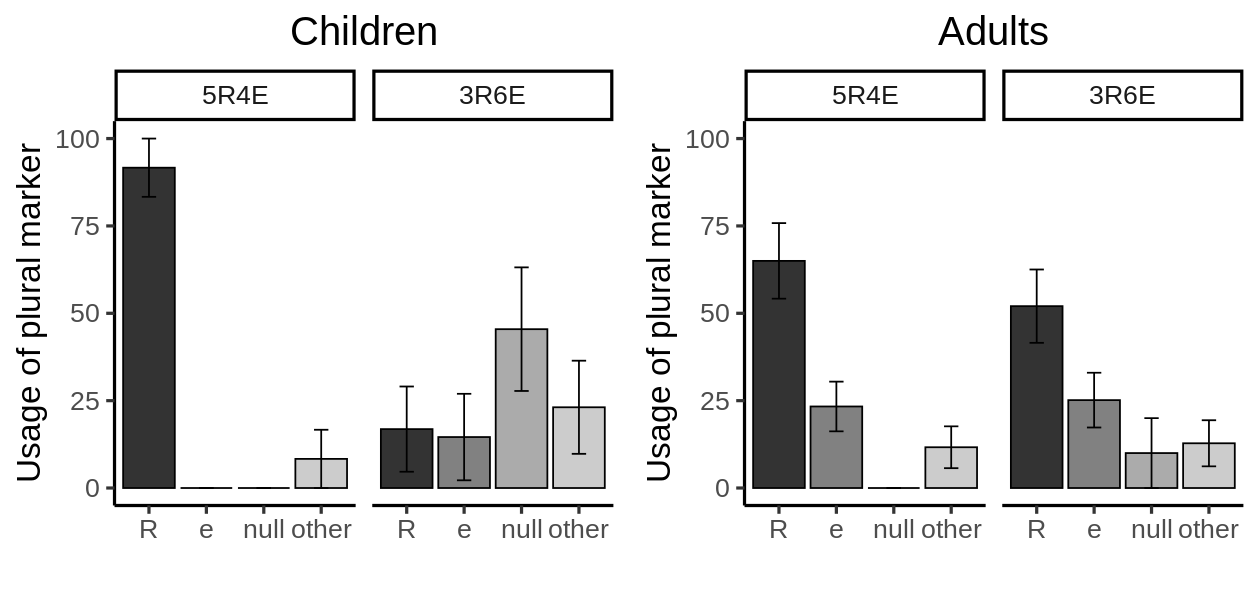

In [7]:
# plot these results for kids and adults to make figure 2
options(repr.plot.width = 10.5, repr.plot.height = 5)

#input levels
input <- data.frame(condition = c("5R4E", "3R6E"), input = c(75, 58.3)) %>%
  mutate(condition = factor(condition, levels = c("5R4E", "3R6E")))


exp1_child_prod <- ggplot(filter(exp1_production_group, age_group == "Child"), 
                          aes(marker_type, mean, fill = marker_type))+
  facet_grid(.~ condition, scales = "free", space = "free") +
  geom_bar(stat = "identity", position = position_dodge(), color = "black") +
  geom_errorbar(aes(ymin = mean - sem,
                    ymax = mean + sem), 
                    position = position_dodge(width=0.9), width = 0.25)+
  coord_cartesian(ylim = c(0, 100)) +
  labs(x = "", y = "Usage of plural marker", title = "Children") +
  theme(legend.position = "None") +
  scale_fill_grey() 


exp1_adult_prod <- ggplot(filter(exp1_production_group, age_group == "Adult"), 
                          aes(marker_type, mean, fill = marker_type))+
  facet_grid(.~ condition, scales = "free", space = "free") +
  geom_bar(stat = "identity", position = position_dodge(), color = "black") +
  geom_errorbar(aes(ymin = mean - sem,
                    ymax = mean + sem), 
                    position = position_dodge(width=0.9), width = 0.25)+
  coord_cartesian(ylim = c(0, 100)) +
  labs(x = "", y = "Usage of plural marker", title = "Adults") +
  theme(legend.position = "None") +
  scale_fill_grey() 

grid.arrange(exp1_child_prod, exp1_adult_prod, ncol=2)

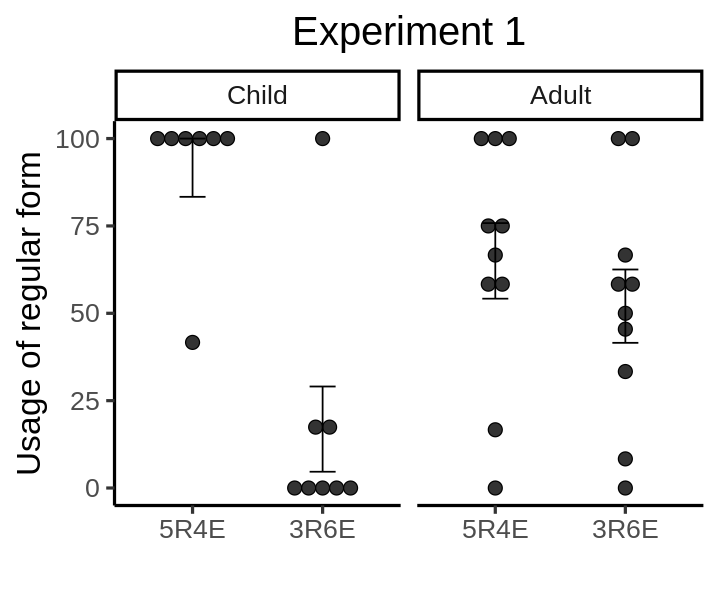

In [8]:
# make figure 3: usage of regular for by individuals
options(repr.plot.width = 6, repr.plot.height = 5)

exp1_production %>%
    filter(marker_type == "R") %>%
    ggplot(aes(x = condition, y = usage)) +
    facet_grid(.~age_group) + 
    geom_dotplot(binaxis='y', stackdir='center', dotsize=1.0, aes(fill = marker_type), binwidth = 4) +
    stat_summary(fun.data = mean_se, geom = "errorbar", color = "black", width = 0.2) +
    coord_cartesian(ylim = c(0, 100)) +
    scale_fill_grey() +
    theme(legend.position = "None") +
    labs(y = "Usage of regular form", x = "", title = "Experiment 1")

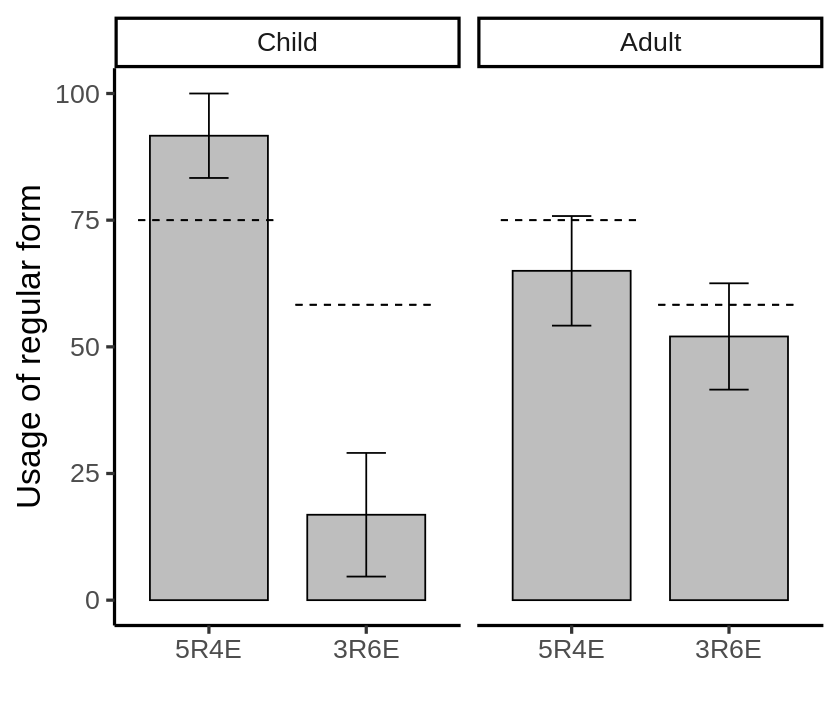

In [9]:
# Make figure 4: usage of regular form compared to token fq of input
options(repr.plot.width = 7, repr.plot.height = 6)

exp1_production_group %>%
    filter(marker_type == "R") %>%
    mutate(input = ifelse(condition == "5R4E", 75, 58.3)) %>%
    ggplot(aes(condition, mean, fill = age_group)) +
      facet_grid(.~age_group, labeller = label_wrap_gen(width=10)) +
      geom_bar(stat="identity", width = 0.75, color = 'black') +
      geom_errorbar(aes(ymin = mean - sem,
                        ymax = mean + sem), 
                        position = position_dodge(width=0.9), width = 0.25)+
      geom_errorbar(aes(ymax=input, ymin=input), linetype="dashed") +
      labs(x = "", y = "Usage of regular form") +
      scale_fill_manual( values = c("gray", "gray")) +
      theme(legend.position = "None")

#### t-tests against hypothesized values

We'll do logistic regression to see if use of the regular form differs across conditions; but our actual hypothesis is whether children in 5R4E always use the regular form and those in 3R6E use it no more than chance. We can test this with ttests against hypothesized values.

In [10]:
# do a one sample ttest against the Tolerance Principle's predictions
exp1_production %>% 
  filter(marker_type %in% c("R")) %>%  
  mutate(mu = ifelse(condition == "5R4E", 100, 14.29),
        alt = ifelse(condition == "5R4E", "less", "greater"))%>%
  group_by(age_group, condition) %>%
  do(tidy(t.test(x=.$usage, mu=min(.$mu),  data=., alternative=min(.$alt)))) 

age_group,condition,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Child,5R4E,91.66667,-1.000000,0.177958842,6,-Inf,107.85984,One Sample t-test,less
Child,3R6E,16.85606,0.210329,0.419701035,7,-6.258217,Inf,One Sample t-test,greater
Adult,5R4E,65.00000,-3.236093,0.005111206,9,-Inf,84.82606,One Sample t-test,less
Adult,3R6E,52.04545,3.598138,0.002882524,9,32.810500,Inf,One Sample t-test,greater


Kids use the regualar form not greater than chance in 3R6E and not less than 100% in the 5R4E condition. Adults on the other hand use it significantly less than all the time in 5R4E and signficaintly greater than chance in the 3R6E condition. 

In [11]:
# next let's check if kids or adults match the Token frequency 
exp1_production %>% 
  filter(marker_type %in% c("R")) %>%  
  mutate(mu = ifelse(condition == "5R4E", 75.51, 59.18), alt = "two.sided")%>%
  group_by(age_group, condition) %>%
  do(tidy(t.test(x=.$usage, mu=min(.$mu),  data=., alternative=min(.$alt)))) 

age_group,condition,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Child,5R4E,91.66667,1.9388000,0.10060915,6,71.27573,112.05760,One Sample t-test,two.sided
Child,3R6E,16.85606,-3.4691125,0.01041838,7,-11.99288,45.70500,One Sample t-test,two.sided
Adult,5R4E,65.00000,-0.9717524,0.35656434,9,40.53361,89.46639,One Sample t-test,two.sided
Adult,3R6E,52.04545,-0.6799303,0.51365595,9,28.30852,75.78239,One Sample t-test,two.sided


#### logistic mixed effects regression

Next we'll use a logistic mixed effects model to predict use of the regular form by condition in kids, then a seperate model for adults. After that, we'll do a model with both, including age_group as an interaction term. We're using dummy coding here and a simple random effects structure (1|random_id). 

In [12]:
# kid model
logme_exp1_kids <- glmer(regular_form ~ condition + (1|random_id), 
                         family = "binomial",
                         data = filter(exp1_prod, corr_noun == TRUE, age_group == "child"))
summary(logme_exp1_kids)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition + (1 | random_id)
   Data: filter(exp1_prod, corr_noun == TRUE, age_group == "child")

     AIC      BIC   logLik deviance df.resid 
    67.1     76.5    -30.5     61.1      166 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-0.86142 -0.01301  0.00594  0.00594  2.28615 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 94.24    9.708   
Number of obs: 169, groups:  random_id, 15

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)     -8.509      3.170  -2.684  0.00727 **
condition5R4E   18.721      5.813   3.221  0.00128 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
conditn5R4E -0.818

In [13]:
# adult model
logme_exp1_adults <- glmer(regular_form ~ condition + (1|random_id), 
                           family = "binomial",
                           data = filter(exp1_prod, corr_noun == TRUE, age_group == "adult"))
summary(logme_exp1_adults)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition + (1 | random_id)
   Data: filter(exp1_prod, corr_noun == TRUE, age_group == "adult")

     AIC      BIC   logLik deviance df.resid 
   257.8    268.2   -125.9    251.8      236 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7303 -0.5101  0.1941  0.6979  2.7155 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 5.063    2.25    
Number of obs: 239, groups:  random_id, 20

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)     0.1943     0.7637   0.254    0.799
condition5R4E   0.8788     1.0884   0.807    0.419

Correlation of Fixed Effects:
            (Intr)
conditn5R4E -0.699

In [14]:
# both model with age interaction
logme_exp1_both <- glmer(regular_form ~ condition * age_group + (1|random_id), 
                                family = "binomial", 
                                data = filter(exp1_prod, corr_noun == TRUE))
summary(logme_exp1_both)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition * age_group + (1 | random_id)
   Data: filter(exp1_prod, corr_noun == TRUE)

     AIC      BIC   logLik deviance df.resid 
   328.4    348.5   -159.2    318.4      403 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.73859 -0.20258  0.04726  0.17213  2.92513 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 9.427    3.07    
Number of obs: 408, groups:  random_id, 35

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                    0.2638     1.0465   0.252  0.80100   
condition5R4E                  1.0021     1.4998   0.668  0.50404   
age_groupchild                -3.9320     1.8465  -2.129  0.03322 * 
condition5R4E:age_groupchild   8.5185     2.8530   2.986  0.00283 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

## Experiment 2

In [15]:
exp2_production <- filter(exp2_prod, corr_noun == "true") %>% 

    # count how many corr trials each participant had
    group_by(random_id, .drop = FALSE) %>%
    add_tally(name = 'n') %>%
    ungroup %>%

    # then groupby marker_type and fill in any the participant didn't use with 0
    group_by(age_group, condition, language, n, random_id, marker_type, .drop = FALSE) %>%
    tally(name = 'n_marker') %>%
    ungroup %>%
    complete(nesting(age_group, condition, language, random_id, n), nesting(marker_type), fill = list(n_marker = 0)) %>%
   
    # reorder the factors so they look nice in our plots
    mutate(
      usage = n_marker/n*100,
      condition = factor(condition, levels = c("5R4E", "3R6E")),
      age_group = factor(age_group, levels = c("child", "adult"), labels = c("Child", "Adult")),
      marker_type = factor(marker_type, levels = c("R", "e", "null", "other")),
      experiment = "Experiment 2"
    )


### Participants



In [16]:
# get the number of participants in each age group / condition with at least 6 nouns correct
exp2_production %>%
  group_by(age_group, condition) %>%
  summarise(n_participants = n_distinct(random_id)) 

age_group,condition,n_participants
<fct>,<fct>,<int>
Child,5R4E,13
Child,3R6E,7
Adult,5R4E,8
Adult,3R6E,7


### Results

The Tolerance Principle predicts that children should behave categorically. This means they should use the regular form on ALL test trials (form a productive rule) in the 5R4E condition and use the regular form no more than chance in the 3R6E condition. 

#### Figures



In [17]:
# first get the usage of each marker type by condition and age 
exp2_production_group <- exp2_production %>%  
  group_by(age_group, condition, marker_type) %>%
  summarise(n = n(), mean = mean(usage), sd = sd(usage), sem = sd/sqrt(n)) 

# print usage of regular form for each age_group and condition
exp2_production_group %>% filter(marker_type == "R") 

age_group,condition,marker_type,n,mean,sd,sem
<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Child,5R4E,R,13,54.627040,44.87964,12.447372
Child,3R6E,R,7,7.142857,18.89822,7.142857
Adult,5R4E,R,8,71.117424,25.01291,8.843399
Adult,3R6E,R,7,63.095238,10.60348,4.007740


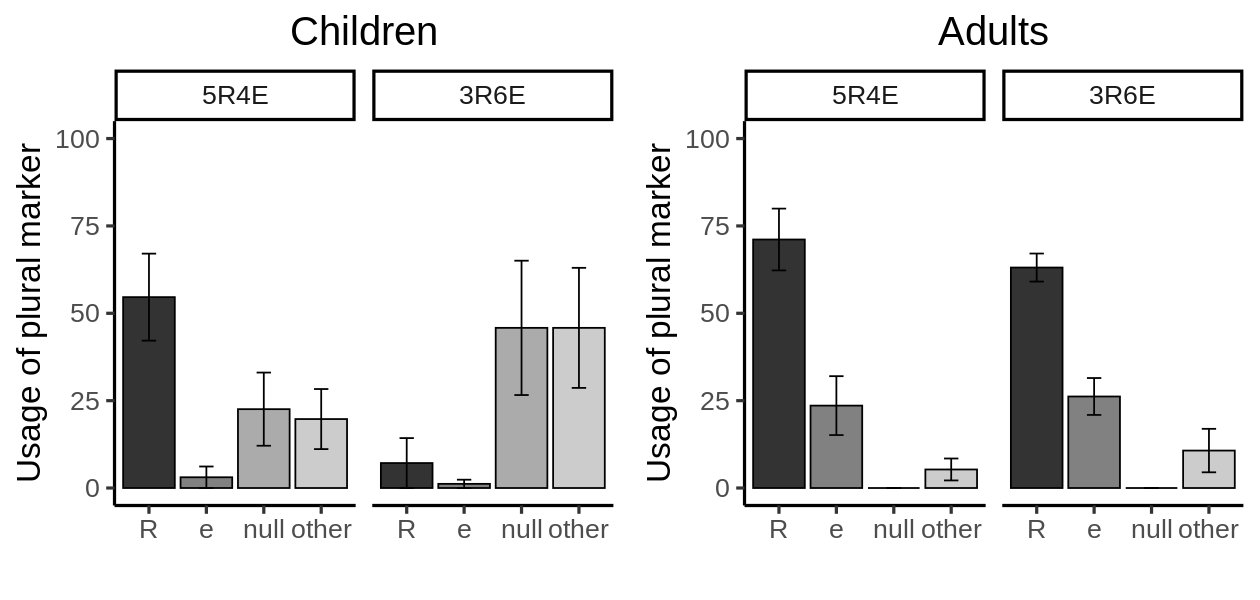

In [18]:
# plot these results for kids and adults to make figure 5
options(repr.plot.width = 10.5, repr.plot.height = 5)

exp2_child_prod <- ggplot(filter(exp2_production_group, age_group == "Child"), 
                          aes(marker_type, mean, fill = marker_type))+
  facet_grid(.~ condition, scales = "free", space = "free") +
  geom_bar(stat = "identity", position = position_dodge(), color = "black") +
  geom_errorbar(aes(ymin = mean - sem,
                    ymax = mean + sem), 
                    position = position_dodge(width=0.9), width = 0.25)+
  coord_cartesian(ylim = c(0, 100)) +
  labs(x = "", y = "Usage of plural marker", title = "Children") +
  theme(legend.position = "None") +
  scale_fill_grey() 


exp2_adult_prod <- ggplot(filter(exp2_production_group, age_group == "Adult"), 
                          aes(marker_type, mean, fill = marker_type))+
  facet_grid(.~ condition, scales = "free", space = "free") +
  geom_bar(stat = "identity", position = position_dodge(), color = "black") +
  geom_errorbar(aes(ymin = mean - sem,
                    ymax = mean + sem), 
                    position = position_dodge(width=0.9), width = 0.25)+
  coord_cartesian(ylim = c(0, 100)) +
  labs(x = "", y = "Usage of plural marker", title = "Adults") +
  theme(legend.position = "None") +
  scale_fill_grey() 



grid.arrange(exp2_child_prod, exp2_adult_prod, ncol=2)

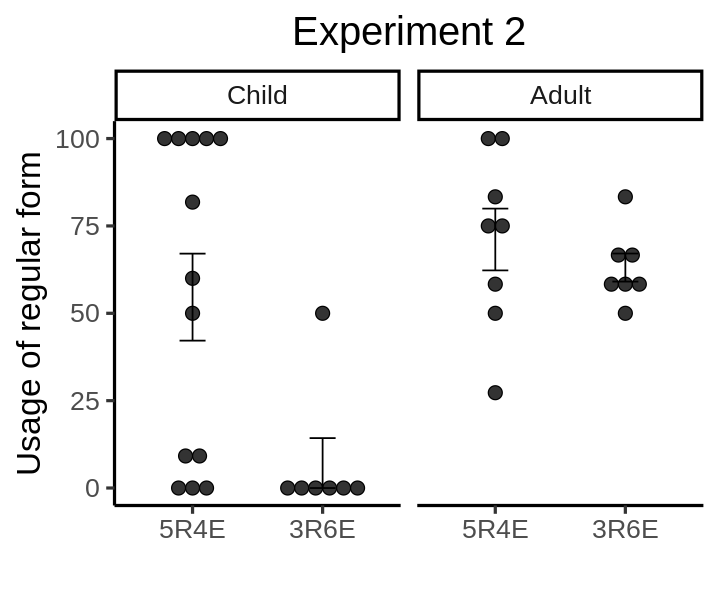

In [19]:
# make figure 6: usage of regular for by individuals
options(repr.plot.width = 6, repr.plot.height = 5)

exp2_production %>%
    filter(marker_type == "R") %>%
    ggplot(aes(x = condition, y = usage)) +
    facet_grid(.~age_group) + 
    geom_dotplot(binaxis='y', stackdir='center', dotsize=1.0, aes(fill = marker_type), binwidth = 4) +
    stat_summary(fun.data = mean_se, geom = "errorbar", color = "black", width = 0.2) +
    coord_cartesian(ylim = c(0, 100)) +
    scale_fill_grey() +
    theme(legend.position = "None") +
    labs(y = "Usage of regular form", x = "", title = "Experiment 2")

#### t-tests against hypothesized values

We'll do logistic regression to see if use of the regular form differs across conditions; but our actual hypothesis is whether children in 5R4E always use the regular form and those in 3R6E use it no more than chance. We can test this with ttests against hypothesized values.

In [20]:
# do a one sample ttest against the Tolerance Principle's predictions
exp2_production %>% 
  filter(marker_type %in% c("R")) %>%  
  mutate(mu = ifelse(condition == "5R4E", 100, 14.29),
        alt = ifelse(condition == "5R4E", "less", "greater"))%>%
  group_by(age_group, condition) %>%
  do(tidy(t.test(x=.$usage, mu=min(.$mu),  data=., alternative=min(.$alt)))) 

age_group,condition,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Child,5R4E,54.627040,-3.645184,1.678017e-03,12,-Inf,76.81184,One Sample t-test,less
Child,3R6E,7.142857,-1.000600,8.221750e-01,6,-6.737002,Inf,One Sample t-test,greater
Adult,5R4E,71.117424,-3.266004,6.874972e-03,7,-Inf,87.87194,One Sample t-test,less
Adult,3R6E,63.095238,12.177745,9.324685e-06,6,55.307477,Inf,One Sample t-test,greater


The results here are different. Kids still use the regualar form not greater than chance in 3R6E, but in 5R4E, they use it signficantly less than 100%. Adults behave the same as in experiment 1: using the regular form significantly less than all the time in 5R4E and signficaintly greater than chance in the 3R6E condition. 

#### logistic mixed effects regression

Next we'll use a logistic mixed effects model to predict use of the regular form by condition in kids, then a seperate model for adults. After that, we'll do a model with both, including age_group as an interaction term. We're using dummy coding here and a simple random effects structure (1|random_id). 

In [21]:
# kid model
logme_exp2_kids <- glmer(regular_form ~ condition + (1|random_id), 
                         family = "binomial",
                         data = filter(exp2_prod, corr_noun == "true", age_group == "child"))
summary(logme_exp2_kids)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition + (1 | random_id)
   Data: filter(exp2_prod, corr_noun == "true", age_group == "child")

     AIC      BIC   logLik deviance df.resid 
   124.1    134.3    -59.0    118.1      221 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.11416 -0.12161 -0.01698  0.09782  3.12917 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 30.71    5.542   
Number of obs: 224, groups:  random_id, 20

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)     -8.045      2.480  -3.245  0.00118 **
condition5R4E    9.202      3.376   2.726  0.00641 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
conditn5R4E -0.824

As predicted, children use the regular form signficantly less than chance in the 3R6E condition (reference level) and signficantly more in the 5R4E condition. Again, this doesn't really test our specific hypotheses: that they'll use it 100% of the time in 5R4E and no more than chance in 3R6E, but I'm including it here to be complete. 

In [22]:
# adult model
logme_exp2_adults <- glmer(regular_form ~ condition + (1|random_id), 
                           family = "binomial",
                           data = filter(exp2_prod, corr_noun == "true", age_group == "adult"))
summary(logme_exp2_adults)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition + (1 | random_id)
   Data: filter(exp2_prod, corr_noun == "true", age_group == "adult")

     AIC      BIC   logLik deviance df.resid 
   226.4    236.0   -110.2    220.4      176 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8986 -1.1345  0.5267  0.7278  1.0066 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 0.4219   0.6495  
Number of obs: 179, groups:  random_id, 15

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)     0.5702     0.3388   1.683   0.0923 .
condition5R4E   0.4564     0.4788   0.953   0.3405  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
conditn5R4E -0.700

With adults no significant difference in use of the regular form across conditions. 

In [23]:
# both model with age interaction
logme_exp2_both <- glmer(regular_form ~ condition * age_group + (1|random_id), 
                                family = "binomial", 
                                data = filter(exp2_prod, corr_noun == "true"))
summary(logme_exp2_both)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: regular_form ~ condition * age_group + (1 | random_id)
   Data: filter(exp2_prod, corr_noun == "true")

     AIC      BIC   logLik deviance df.resid 
   368.7    388.7   -179.4    358.7      398 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2301 -0.2595  0.1658  0.4916  2.7524 

Random effects:
 Groups    Name        Variance Std.Dev.
 random_id (Intercept) 6.375    2.525   
Number of obs: 403, groups:  random_id, 35

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                    0.6194     0.9853   0.629  0.52957   
condition5R4E                  0.9282     1.3914   0.667  0.50472   
age_groupchild                -5.8239     1.7796  -3.273  0.00107 **
condition5R4E:age_groupchild   4.7968     2.1633   2.217  0.02660 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Same result as experiment 1: children are significantly less likely to use the regular form than adults, but this depends on condition. Children in the 5R4E conditon are signifcantly more likely to use the regular form. 

Again, we aren't testing our actual a-priori hypothesis here: that children will use the regular for 100% of the time in the 5R4E condition and no more than chance in 3R6E, but I'm including the regressions to be complete.

## personal TP for children

Some kids in 5R4E behaved categorically, but not as the TP would predict. We decided to use their rating test to calculate a personal Tolerance Principle for each kid, based on the number of nouns they know. 

In [24]:
personal_tp <- exp2_rate %>% 

    # make sure age_group is a factor
    mutate(age_group = factor(age_group, labels = c("Adult", "Child"))) %>%

    # group by participant and see the pcnt correct for each noun
    group_by(age_group, condition, random_id, noun, correct_choice) %>%
    summarise(n_correct = sum(is_correct), n = n(), pcnt_corr = n_correct/n*100) %>%
    
    # if they got 100% correct, mark as learned
    mutate(learned = ifelse(pcnt_corr == 100, 1, 0)) %>%

    # get whether the noun was a regular or exception in the input
    mutate(form = ifelse(correct_choice == "ka", "R", "e")) %>%

    # count how many each participant learned for R and e
    group_by(age_group, condition, random_id, form) %>%
    summarise(n_learned = sum(learned)) %>%

    # spread R and e out so we can calcuate personal TP
    spread(form, n_learned) %>%
    ungroup() %>%

    # let's get their N (how many they learned total) and calculate personal TP 
    mutate( 
        N = e + R, 
        personalTP = N/log(N),
        prediction = ifelse(R > 1, ifelse(e > personalTP, "Unproductive", "Productive"), "Unproductive"))
    

In [25]:
kid_prod_and_pTP <- personal_tp %>%

    # join the production data to the personal_tp data
    left_join(exp2_production, by = c("age_group", "condition", "random_id")) %>%

    # get the categorical kids use of regular form
    filter(age_group == "Child", n > 5, !between(usage, 15, 99), marker_type == "R") %>%

    # select the relevant columns
    select(age_group, condition, random_id, prediction, usage) %>%
    mutate(condition = factor(condition, levels = c("5R4E", "3R6E"))) %>%
    arrange(prediction, random_id)

In [26]:
kid_prod_and_pTP

age_group,condition,random_id,prediction,usage
<fct>,<fct>,<chr>,<chr>,<dbl>
Child,5R4E,1e9jQang,Productive,100.000000
Child,5R4E,cMHNPS0S,Productive,100.000000
Child,5R4E,lEvuNZdV,Productive,100.000000
Child,5R4E,OXq608k0,Productive,100.000000
Child,5R4E,sSeSQr3C,Productive,100.000000
Child,5R4E,XP2fHc4D,Productive,0.000000
Child,3R6E,0t5IeYAg,Unproductive,0.000000
Child,5R4E,4OBi0SLE,Unproductive,10.000000
Child,3R6E,c6xkBiUK,Unproductive,0.000000


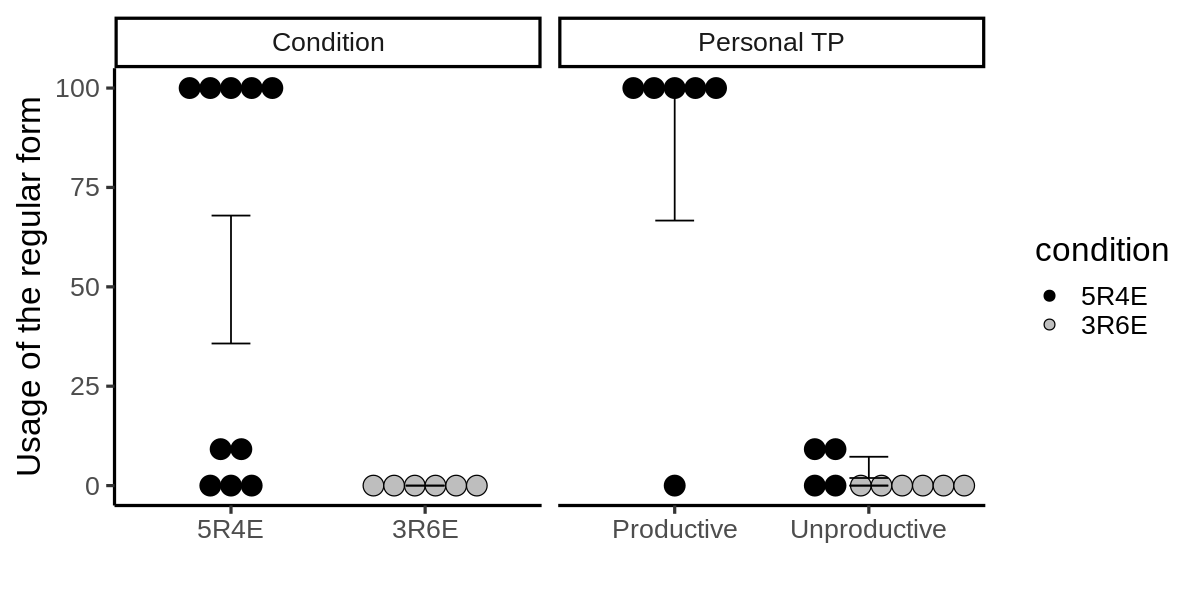

In [27]:
# figure 7 - usage of the regular form by categorical children
options(repr.plot.width = 10, repr.plot.height = 5)

by_condition <- kid_prod_and_pTP %>% mutate(grouping = "Condition", group = condition)
by_personalTP <- kid_prod_and_pTP %>% mutate(grouping = "Personal TP", group = prediction)

ggplot(rbind(by_condition, by_personalTP), aes(x = group, y = usage, fill = condition)) +
    facet_grid(.~ grouping, scales = "free") +
    coord_cartesian(ylim = c(0, 100)) +
    geom_dotplot(binaxis='y', stackdir='center', dotsize=1.3, binwidth = 4, position = "dodge") +
    stat_summary(fun.data = mean_se, geom = "errorbar", color = "black", width = 0.2) +
    scale_fill_manual(values = c("black", "grey")) +
    labs(x = "", y = "Usage of the regular form") 
